# Procesamiento de datos a través de PySpark

#### Autores
- Adrián Fernández Galán
- Alvaro Guerrero Espinosa
- Jose Antonio Verde Jiménez
- Carlos Salinas Gancedo

## Práctica de HPC - Yellow Trips 🗽
El objetivo de este proyecto es diseñar y ejecutar 3 análisis diferentes a través de una pipeline de procesamiento de datos masivos usando los registros de viajes de taxis y vehículos de transporte de la ciudad de Nueva York ([TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)), donde unos de los análsis debe de explorar 3 implementaciones diferentes a través de `DATAFRAMES`, `SQL` y `RDD`.

Los 3 análisis son los siguientes:
1. Coste medio por viaje por minuto y zona de taxis de New York.
2. Número de viajes de taxis que terminan en disputas por barrio
3. Velocidad media en función de la hora

Los análisis 1 y 2 se han implementado usando únicamente `DATAFRAMES`, mientras que el análisis 3 se ha implementado usando `DATAFRAMES`, `SQL` y `RDD`.

### Configuración de Spark
Para la configuración de Spark, se ha utilizado el siguiente fragmento de código:

In [49]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import col, unix_timestamp, avg, to_timestamp, round


spark = SparkSession.builder.master('local[*]').getOrCreate()

spark

### Lectura de datos
Para la lectura de los datos, en formato `parquet`, se ha utilizado la siguiente línea de código:

In [50]:
df_orig = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("data/yellow_tripdata_2024-01.parquet")

### Carga de zonas y distritos
Para la carga de las zonas y distritos, se ha utilizado la siguiente línea de código:

In [51]:
zones = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)

## Coste medio por viaje por minuto y zona de taxis de New York


A continuación se calcula la duración de los viajes a partir de la hora de recogida y llegada

In [52]:
df = (
    df_orig.withColumn("tpep_pickup_datetime", to_timestamp("tpep_pickup_datetime"))
      .withColumn("tpep_dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))
)

df = df.withColumn(
    "duration_hours",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 3600
)

Para evitar viajes con duración 0, se filtran estos viajes.

In [53]:
df_valid = df.filter(col("duration_hours") != 0)

Tras esto se calcula el coste por minuto por viaje

In [54]:
df_valid = df_valid.withColumn(
    "cost_per_minute",
    col("total_amount") / (col("duration_hours") * 60)
)

Combinando las tablas de las zonas y distritos con los viajes se obtiene un dataframe con la información necesaria para calcular el coste medio por viaje y zona.

In [55]:
df_joined = df_valid.join(
    zones,
    df_valid["PULocationID"] == zones["LocationID"],
    "left"
)

Y finalmente se calcula la media del coste por minuto agrupada por zona de recogida.

In [56]:
avg_cost_per_zone = (
    df_joined.groupBy("Zone", "Borough")
    .agg(avg("cost_per_minute").alias("avg_cost_per_minute"))
    .orderBy(col("avg_cost_per_minute").desc())
)

#### Visualización de los resultados

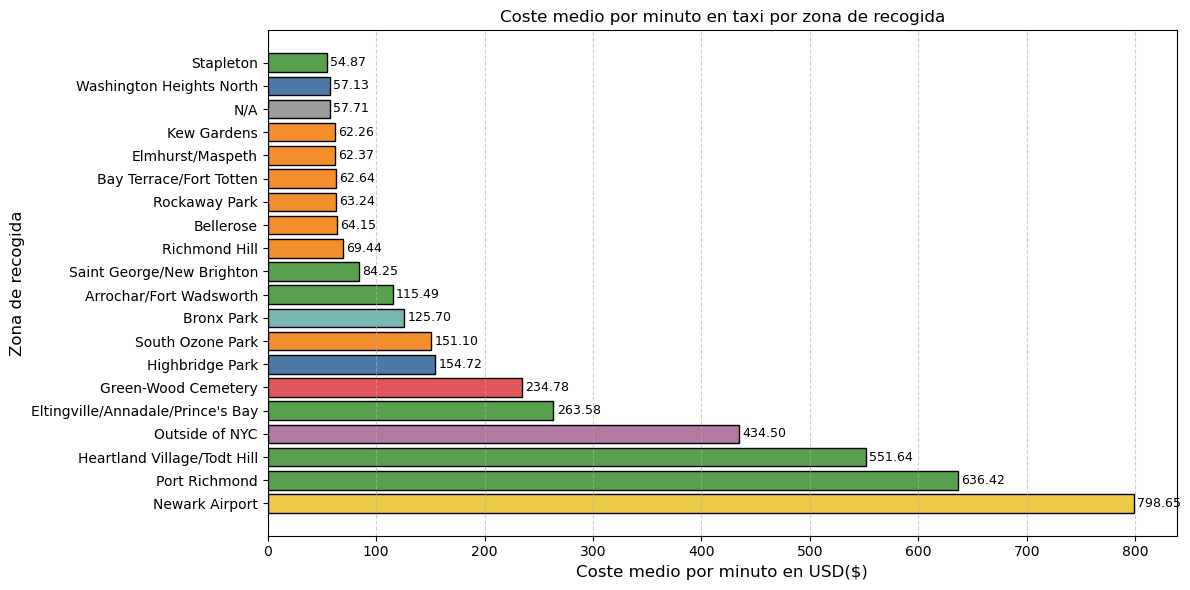

In [57]:
import matplotlib.pyplot as plt

zone_data = avg_cost_per_zone.collect()
top_zones = sorted(zone_data, key=lambda x: x["avg_cost_per_minute"], reverse=True)[:20]

x = [z["Zone"] for z in top_zones]
y = [z["avg_cost_per_minute"] for z in top_zones]
boroughs = [z["Borough"] for z in top_zones]

color_map = {
    "Manhattan": "#4E79A7",
    "Queens": "#F28E2B",
    "Brooklyn": "#E15759",
    "Bronx": "#76B7B2",
    "Staten Island": "#59A14F",
    "EWR": "#EDC948",
    "N/A": "#B07AA1"
}
colors = [color_map.get(b, "#9c9c9c") for b in boroughs]

plt.figure(figsize=(12, 6))
bars = plt.barh(x, y, color=colors, edgecolor='black')

plt.xlabel("Coste medio por minuto en USD($)", fontsize=12)
plt.ylabel("Zona de recogida", fontsize=12)
plt.title("Coste medio por minuto en taxi por zona de recogida")
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 3, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## Probabilidad de que los viajes de taxis que terminan en disputas según el barrio

Para conseguir el número de viajes que terminan en disputas por barrio, se filtran los viajes donde el "tipo" de pago es "disputa", y con esto se hace un join con la tabla de barrios para obtener el barrio correspondiente a cada viaje.
Para obtener la probabilidad de disputa por barrio, se cuenta el número total de viajes por barrio y se divide el número de viajes en disputa entre el número total de viajes.

En nuestro caso, se ha decidido observar la probabilidad de disputa según el barrio de recogida y el barrio de destino.

In [58]:
disputes = df_orig.filter(df.payment_type == 4).join(zones, df.PULocationID == zones.LocationID).groupBy("Borough").count()
nodisputes = df.filter(df.payment_type != 4).join(zones, df.PULocationID == zones.LocationID).groupBy("Borough").count().withColumnRenamed("count", "nocount")
combined = disputes.join(nodisputes, "Borough")
PUresult = combined.withColumn("Probability", combined["count"] / (combined["count"] + combined["nocount"])).orderBy("Probability")

In [ ]:
disputes = df_orig.filter(df.payment_type == 4).join(zones, df.DOLocationID == zones.LocationID).groupBy("Borough").count()
nodisputes = df.filter(df.payment_type != 4).join(zones, df.DOLocationID == zones.LocationID).groupBy("Borough").count().withColumnRenamed("count", "nocount")
combined = disputes.join(nodisputes, "Borough")
DOresult = combined.withColumn("Probability", combined["count"] / (combined["count"] + combined["nocount"])).orderBy("Probability")

,Borough,count,nocount,Probability
0,Unknown,117,15999,0.007260
1,Manhattan,37592,2619158,0.014150
2,EWR,114,7062,0.015886
3,Brooklyn,2079,105139,0.019390
4,Queens,5451,141536,0.037085
5,N/A,448,11519,0.037436
6,Bronx,794,16957,0.044730
7,Staten Island,33,626,0.050076


#### Visualización de los resultados

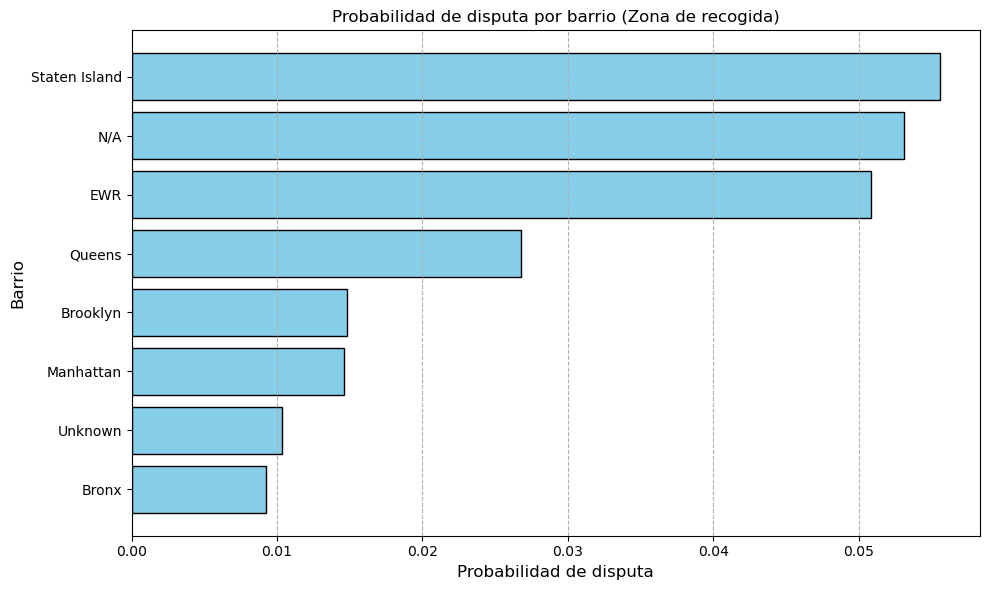

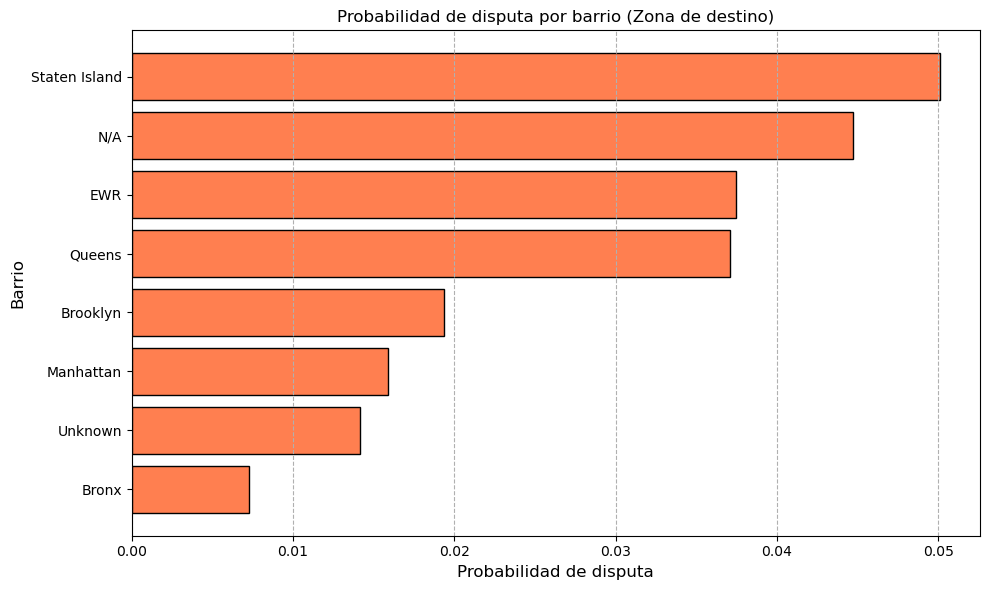

In [ ]:
PUdata = PUresult.collect()
DOdata = DOresult.collect()

x = [x["Borough"] for x in PUdata]
PUy = [y["Probability"] for y in PUdata]
DOy = [y["Probability"] for y in DOdata]

# Gráfico 1: Pick Up
plt.figure(figsize=(10, 6))
plt.barh(x, PUy, color='skyblue', edgecolor='black')
plt.ylabel("Barrio", fontsize=12)
plt.xlabel("Probabilidad de disputa", fontsize=12)
plt.title("Probabilidad de disputa por barrio (Zona de recogida)")
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

# Gráfico 2: Drop Off
plt.figure(figsize=(10, 6))
plt.barh(x, DOy, color='coral', edgecolor='black')
plt.ylabel("Barrio", fontsize=12)
plt.xlabel("Probabilidad de disputa", fontsize=12)
plt.title("Probabilidad de disputa por barrio (Zona de destino)")
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

## Velocidad media en función de la hora

### Dataframes

Primero seleccionamos las columnas relacionadas con la hora de recogida, hora de llegada y distancia del viaje.

In [61]:
df= df_orig.select(["tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance"])

Se calcula la duración del viaje, la distancia recorrida y la hora de recogida.

In [62]:
df = (
    df_orig
        # Distancia en millas a kilómetros
        .withColumn("distance", df_orig["trip_distance"] * 1.60934)
        # Duración en horas. `timestamp_diff` trunca la parte decimal, por lo que calculamos la duración en segundos
        # y la convertimos a horas manualmente
        .withColumn("duration", F.timestamp_diff("second", "tpep_pickup_datetime", "tpep_dropoff_datetime") / 3600)
        # Hora de inicio del viaje
        .withColumn("hour", F.hour("tpep_pickup_datetime"))
)

Se eliminan aquellos viajes con duración 0

In [63]:
df_clean = df.filter(df.duration != 0)

Por último se calcula la velocidad media por hora del día y se ordenan de menor a mayor.

In [64]:
df_result = df_clean.withColumn("speed", df["distance"] / df["duration"]).groupBy("hour").avg("speed")
df_result.sort(df_result.hour.asc()).toPandas()

,hour,avg(speed)
0,0,24.549710
1,1,24.112866
2,2,22.158310
3,3,23.352761
4,4,29.637736
5,5,57.650991
6,6,89.448763
7,7,50.871505
8,8,26.505114
9,9,18.092813


### SQL

Para la implementación en SQL, se crean diferentes vistas temporales para cada uno de los pasos de la pipeline.

In [65]:
df_orig = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("data")
df_orig.createOrReplaceTempView("yellow_trip_orig")

A continuación se obtiene la distancia recorrida, la duración del viaje y la hora de recogida.

In [66]:
spark.sql("SELECT tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance * 1.60934 AS trip_distance_km FROM yellow_trip_orig").createOrReplaceTempView("yellow_trip_dist_km")

spark.sql("SELECT trip_distance_km, (unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) / 3600 AS duration_hours, hour(tpep_pickup_datetime) AS hour FROM yellow_trip_dist_km").createOrReplaceTempView("yellow_trip")

Realizamos el filtrado de los viajes con duración 0

In [67]:
spark.sql("Select trip_distance_km, duration_hours, hour from yellow_trip Where duration_hours != 0").createOrReplaceTempView("yellow_trip_clean")

Finalmente obtenemos la velocidad media por hora del día y se ordenan de menor a mayor.

In [68]:
df = spark.sql("Select hour, AVG(trip_distance_km / duration_hours) AS avg_speed FROM yellow_trip_clean GROUP BY hour Order By (hour)")

### RDD

In [69]:
rdd_orig = df_orig.rdd
# Se obtienen los datos sobre la distancia recorrida, la hora de recogida y la duración
rdd = rdd_orig.map(lambda x:
                        (x.trip_distance * 1.60934,
                        (x.tpep_dropoff_datetime.timestamp() - x.tpep_pickup_datetime.timestamp()) / 3600,
                        x.tpep_pickup_datetime.hour))
# Se filtran aquellos viajes con duracion 0
rdd_clean = rdd.filter(lambda x: x[1] != 0)

# Se crea una tupla donde la clave es la hora
# y el valor es una tupla velocidad y contador
rdd = rdd_clean.map(lambda x: (
    x[2],
    (x[0]/x[1],1)
))

# Se aplica un reduce en el que se suman las velocidades y los recuentos
rdd_reduced = rdd.reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))

# Con las velocidades y recuentos por hora se puede calcular la media
rdd_avg = rdd_reduced.map(lambda x: (
        x[0],
        x[1][0]/x[1][1]
    ))

result = rdd_avg.sortByKey().collect()

### Visualización de los resultados

Se muestra únicamente los resultados de la implementación en RDDs, dado que el resto son equivalentes.

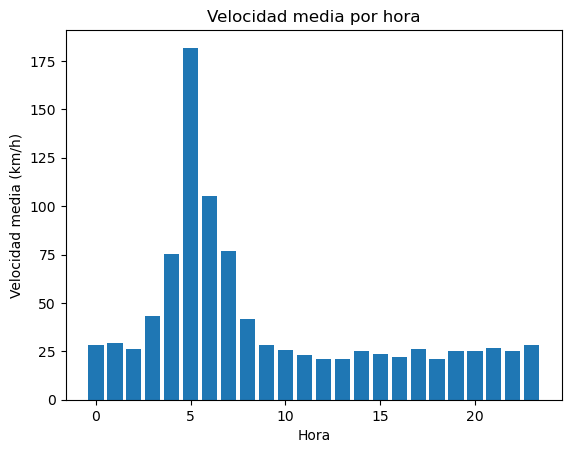

In [70]:
x = [x[0] for x in result]
y = [x[1] for x in result]

plt.bar(x, y)
plt.plot()

plt.xlabel("Hora")
plt.ylabel("Velocidad media (km/h)")
plt.title("Velocidad media por hora")
plt.show()

### Análisis de rendimiento
##### Implementaciones a analizar
Definimos cada una de las implementaciones a analizar como funciones parametrizadas, calculando el tiempo secuencial y paralelo para cada una de ellas:

In [71]:
import time

spark.stop()

def setup(cores):
    return SparkSession.builder.master(f'local[{cores}]').getOrCreate()

def read(spark):
    return spark.read.format("parquet").option("inferSchema", "true") \
        .option("timestampFormat", "yyyy-MM-dd HH:mm:ss") \
        .option("header", "true").option("mode", "DROPMALFORMED").load("data")

def data_frames(cores):
    # === PARTE SERIAL ===
    t_serial_start = time.time()
    spark = setup(cores)
    df_orig = read(spark)
    df_orig = df_orig.select(["tpep_pickup_datetime", "tpep_dropoff_datetime", "trip_distance"])
    t_serial_end = time.time()
    
    # === PARTE PARALELA ===
    t_parallel_start = time.time()
    df = (
        df_orig
            .withColumn("distance", df_orig["trip_distance"] * 1.60934)
            .withColumn("duration", F.timestamp_diff("second", "tpep_pickup_datetime", "tpep_dropoff_datetime") / 3600)
            .withColumn("hour", F.hour("tpep_pickup_datetime"))
    )
    df_result = df.filter(df.duration != 0) \
        .withColumn("speed", df["distance"] / df["duration"]) \
        .groupBy("hour").avg("speed")
    res = df_result.sort(df_result.hour.asc()).toPandas()
    t_parallel_end = time.time()
    
    spark.stop()
    
    t_serial = t_serial_end - t_serial_start
    t_parallel = t_parallel_end - t_parallel_start
    t_total = t_serial + t_parallel
    
    return res, t_serial, t_parallel, t_total

def sql(cores):
    # === PARTE SERIAL ===
    t_serial_start = time.time()
    spark = setup(cores)
    df_orig = read(spark)
    df_orig.createOrReplaceTempView("yellow_trip_orig")
    t_serial_end = time.time()
    
    # === PARTE PARALELA ===
    t_parallel_start = time.time()
    spark.sql("SELECT tpep_pickup_datetime, tpep_dropoff_datetime, trip_distance * 1.60934 AS trip_distance_km FROM yellow_trip_orig") \
        .createOrReplaceTempView("yellow_trip_dist_km")
    
    df = spark.sql("SELECT trip_distance_km, (unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) / 3600 AS duration_hours, hour(tpep_pickup_datetime) AS hour FROM yellow_trip_dist_km")
    df.createOrReplaceTempView("yellow_trip")
    
    df = spark.sql("Select trip_distance_km, duration_hours, hour from yellow_trip Where duration_hours != 0")
    df.createOrReplaceTempView("yellow_trip_clean")
    
    df = spark.sql("Select hour, AVG(trip_distance_km / duration_hours) AS avg_speed FROM yellow_trip_clean GROUP BY hour Order By (hour)")
    res = df.toPandas()
    t_parallel_end = time.time()
    
    spark.stop()
    
    t_serial = t_serial_end - t_serial_start
    t_parallel = t_parallel_end - t_parallel_start
    t_total = t_serial + t_parallel
    
    return res, t_serial, t_parallel, t_total

def rdd(cores):
    # === PARTE SERIAL ===
    t_serial_start = time.time()
    spark = setup(cores)
    df_orig = read(spark)
    rdd_orig = df_orig.rdd
    t_serial_end = time.time()
    
    # === PARTE PARALELA ===
    t_parallel_start = time.time()
    rdd = rdd_orig.map(lambda x:
                        (x.trip_distance * 1.60934,
                        (x.tpep_dropoff_datetime.timestamp() - x.tpep_pickup_datetime.timestamp()) / 3600,
                        x.tpep_pickup_datetime.hour))
    
    rdd_clean = rdd.filter(lambda x: x[1] != 0)
    rdd = rdd_clean.map(lambda x: (x[2], (x[0]/x[1],1)))
    rdd_reduced = rdd.reduceByKey(lambda x,y: (x[0] + y[0], x[1] + y[1]))
    rdd_avg = rdd_reduced.map(lambda x: (x[0], x[1][0]/x[1][1]))
    result = rdd_avg.sortByKey().collect()
    t_parallel_end = time.time()
    
    spark.stop()
    
    t_serial = t_serial_end - t_serial_start
    t_parallel = t_parallel_end - t_parallel_start
    t_total = t_serial + t_parallel
    
    return result, t_serial, t_parallel, t_total

Medimos los tiempos paralelos y secuenciales para diferentes cantidades de hilos:

In [72]:
times = []
for func in (rdd, data_frames, sql):
    res = []
    for i in range(1, 9):
        _, t_serial, t_parallel, t_total = func(i)
        res.append({
            "serial_time": t_serial,
            "parallel_time": t_parallel,
            "total_time": t_total
        })
    times.append(res)

x = list(range(1, 9))

y_total = [[times[j][i]["total_time"] for i in range(8)] for j in range(3)]
y_parallel = [[times[j][i]["parallel_time"] for i in range(8)] for j in range(3)]
y_serial = [[times[j][i]["serial_time"] for i in range(8)] for j in range(3)]

##### Visualización de tiempos obtenidos
A continuación, se muestran los resultados de los tiempos obtenidos para cada una de las implementaciones según el número de hilos utilizados.

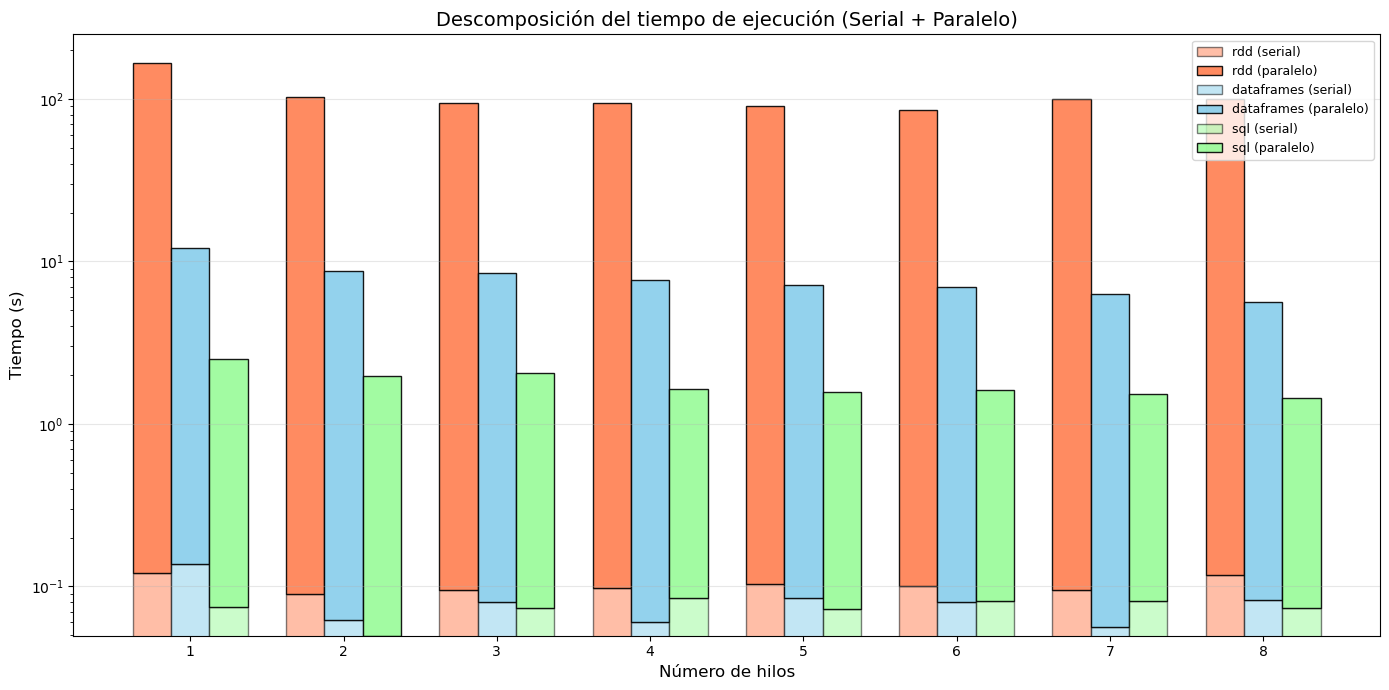

In [83]:
# bars = [("rdd","coral"), ("dataframes", "skyblue"), ("sql", "palegreen"),]

# for i, (label, color) in enumerate(bars):
#     plt.bar(x, y_total[i], label=label, color=color, edgecolor='black')


# plt.plot()

# plt.yscale('log') # Escala logarítmica 
# plt.xlabel("Hilos")
# plt.ylabel("Tiempo (s)")
# plt.title("Tiempo de ejecución")
# plt.legend()
# plt.show()
import numpy as np
bars = [("rdd","coral"), ("dataframes", "skyblue"), ("sql", "palegreen")]

# Configurar el ancho de las barras y posiciones
bar_width = 0.25
x_pos = np.arange(len(x))

plt.figure(figsize=(14, 7))

for i, (label, color) in enumerate(bars):
    # Calcular posición de cada grupo de barras
    positions = x_pos + i * bar_width
    
    # Barras apiladas: primero serial, luego paralelo encima
    plt.bar(positions, y_serial[i], bar_width, 
            label=f'{label} (serial)', color=color, alpha=0.5, edgecolor='black')
    
    plt.bar(positions, y_parallel[i], bar_width, 
            bottom=y_serial[i], label=f'{label} (paralelo)', 
            color=color, alpha=0.9, edgecolor='black')

plt.yscale('log')  # Escala logarítmica
plt.xlabel("Número de hilos", fontsize=12)
plt.ylabel("Tiempo (s)", fontsize=12)
plt.title("Descomposición del tiempo de ejecución (Serial + Paralelo)", fontsize=14)
plt.xticks(x_pos + bar_width, x)  # Centrar etiquetas
plt.legend(fontsize=9, loc='upper right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


##### Análisis de Speedup
Para analizar el speedup obtenido en cada una de las implementaciones, se compara el speedup observado con el speedup teórico según la Ley de Amdahl $$S_{amdahl}(n) = \frac{1}{(1 - P) + \frac{P}{n}}$$, donde la fracción de tiempo paralelizable $P$ se obtiene a partir de los tiempos medidos en la ejecución secuencial y paralela.

In [74]:
def calculate_P(times_list, index):
    # Usar la ejecución con 1 core
    t_serial = times_list[index][0]["serial_time"]
    t_parallel = times_list[index][0]["parallel_time"]
    t_total = t_serial + t_parallel
    
    # P = fracción del tiempo que es paralelizable
    P = t_parallel / t_total
    
    return P

def amdahl_speedup(P,n):
    "Speedup según la Ley de Amdahl"
    return 1 / ((1-P) + P/n)

implementations = ["RDD", "DataFrames", "SQL"]

P_values = []
for i, label in enumerate(implementations):
    P = calculate_P(times, i)
    P_values.append(P)

A continuación, se muestran los gráficos comparativos del speedup observado y teórico para cada una de las implementaciones. Según el número de hilos utilizados.

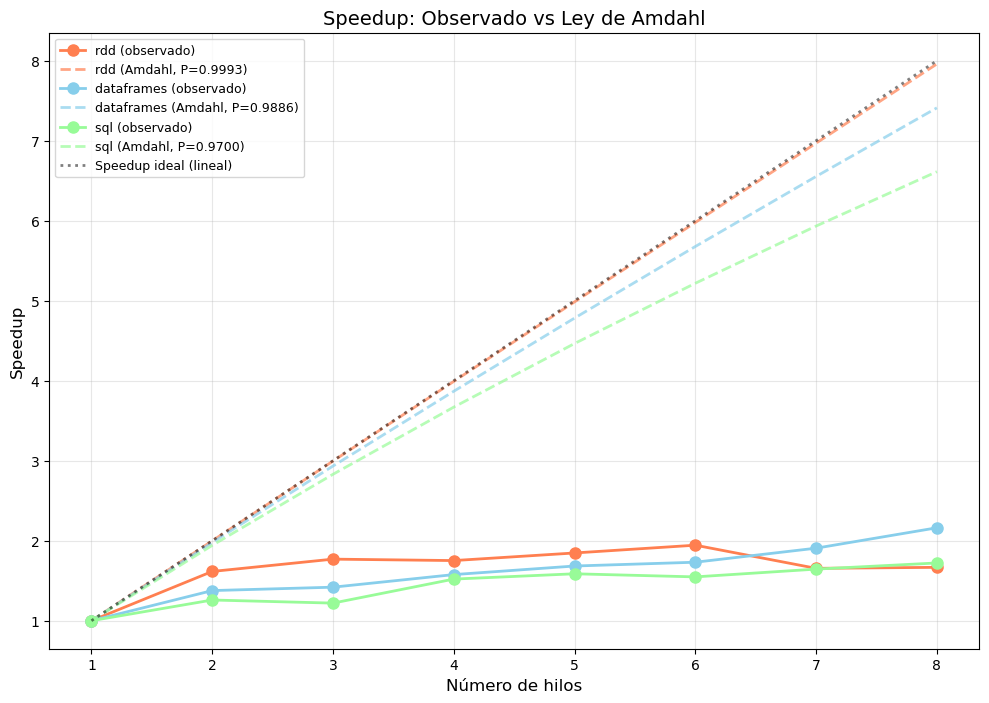

In [75]:
plt.figure(figsize=(12,8))

for i, (label, color) in enumerate(bars):
    # Speedup observado
    speedup_obs = [y_total[i][0]/t for t in y_total[i]]
    plt.plot(x, speedup_obs, marker='o', label=f'{label} (observado)', 
             color=color, linewidth=2, markersize=8)
    
    # Speedup teórico (Amdahl) con P calculado empíricamente
    P = P_values[i]
    speedup_amdahl = [amdahl_speedup(P, n) for n in x]
    plt.plot(x, speedup_amdahl, linestyle='--', label=f'{label} (Amdahl, P={P:.4f})', 
             color=color, linewidth=2, alpha=0.7)

# Speedup ideal (lineal)
plt.plot(x, x, 'k:', label='Speedup ideal (lineal)', linewidth=2, alpha=0.5)

plt.xlabel("Número de hilos", fontsize=12)
plt.ylabel("Speedup", fontsize=12)
plt.title("Speedup: Observado vs Ley de Amdahl", fontsize=14)
plt.legend(fontsize=9, loc='upper left')
plt.grid(True, alpha=0.3)
